# Notebook 05 - Mod√©lisation des √©motions (GoEmotions)

# 1 - Imports & configuration

In [1]:
import os
import sys

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import mlflow
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from sklearn.metrics import classification_report

from src.utils.tree_utils import afficher_arborescence
from src.pipeline_emotions import run_emotion_pipeline
from src.utils.visualization_utils import plot_normalized_metrics, plot_roc_curves, plot_pr_curves, top_k_auc_emotions

W0520 09:54:10.481000 15792 venv_P9_V2\Lib\site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


# 2 - Arborescence du projet

In [2]:
print("üìÇ Arborescence du projet :")
afficher_arborescence('..', niveau_max = 1)

üìÇ Arborescence du projet :
‚îú‚îÄ‚îÄ %USERPROFILE%.git-credentials
‚îú‚îÄ‚îÄ .coverage
‚îú‚îÄ‚îÄ .git
‚îÇ   ‚îú‚îÄ‚îÄ COMMIT_EDITMSG
‚îÇ   ‚îú‚îÄ‚îÄ HEAD
‚îÇ   ‚îú‚îÄ‚îÄ config
‚îÇ   ‚îú‚îÄ‚îÄ description
‚îÇ   ‚îú‚îÄ‚îÄ hooks
‚îÇ   ‚îú‚îÄ‚îÄ index
‚îÇ   ‚îú‚îÄ‚îÄ info
‚îÇ   ‚îú‚îÄ‚îÄ logs
‚îÇ   ‚îú‚îÄ‚îÄ objects
‚îÇ   ‚îú‚îÄ‚îÄ refs
‚îú‚îÄ‚îÄ .github
‚îÇ   ‚îú‚îÄ‚îÄ workflows
‚îú‚îÄ‚îÄ .gitignore
‚îú‚îÄ‚îÄ .history
‚îÇ   ‚îú‚îÄ‚îÄ .github
‚îÇ   ‚îú‚îÄ‚îÄ .gitignore_20250515103945
‚îÇ   ‚îú‚îÄ‚îÄ .gitignore_20250515142538
‚îÇ   ‚îú‚îÄ‚îÄ .gitignore_20250515153648
‚îÇ   ‚îú‚îÄ‚îÄ app_20250515074448.py
‚îÇ   ‚îú‚îÄ‚îÄ app_20250515135249.py
‚îÇ   ‚îú‚îÄ‚îÄ app_20250515135349.py
‚îÇ   ‚îú‚îÄ‚îÄ app_20250515143110.py
‚îÇ   ‚îú‚îÄ‚îÄ app_20250518103623.py
‚îÇ   ‚îú‚îÄ‚îÄ app_20250518103849.py
‚îÇ   ‚îú‚îÄ‚îÄ app_20250518105122.py
‚îÇ   ‚îú‚îÄ‚îÄ requirements_20250515104459.txt
‚îÇ   ‚îú‚îÄ‚îÄ requirements_20250515143348.txt
‚îÇ   ‚îú‚îÄ‚îÄ results
‚îÇ   ‚îú‚îÄ‚îÄ src
‚îÇ   ‚îú‚îÄ‚îÄ tests

# 3 - Chargement du dataset GoEmotions

In [3]:
data_path = os.path.join("..", "data", "raw", "goemotions.csv")
df = pd.read_csv(data_path)

print("‚úÖ Dimensions du dataset :", df.shape)
# df.head()

‚úÖ Dimensions du dataset : (211225, 37)


## 3.1 - Cr√©ation de la colonne "labels" multi-index√©e (0 √† 27)

In [4]:
emotion_cols = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
    'remorse', 'sadness', 'surprise', 'neutral'
]  # colonnes d‚Äô√©motions (28 colonnes apr√®s les m√©tadonn√©es)
df['labels'] = df[emotion_cols].apply(lambda row: [i for i, v in enumerate(row) if v == 1], axis=1)

In [5]:
print("‚úÖ Dimensions du dataset :", df.shape)
print("üìä Nombre moyen d‚Äô√©motions par tweet :", df['labels'].apply(len).mean())
df[['text', 'labels']].head()

‚úÖ Dimensions du dataset : (211225, 38)
üìä Nombre moyen d‚Äô√©motions par tweet : 1.1813421706710854


text labels
0                                    That game hurt.   [25]
1   >sexuality shouldn‚Äôt be a grouping category I...     []
2     You do right, if you don't care then fuck 'em!   [27]
3                                 Man I love reddit.   [18]
4  [NAME] was nowhere near them, he was by the Fa...   [27]

# 4 - Statistiques de base

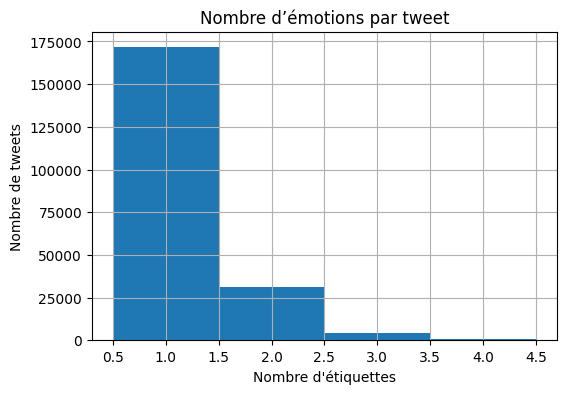

In [6]:
df['n_emotions'] = df['labels'].apply(len)
df['n_emotions'].hist(bins=range(1, 6), align='left', figsize=(6, 4))
plt.title("Nombre d‚Äô√©motions par tweet")
plt.xlabel("Nombre d'√©tiquettes")
plt.ylabel("Nombre de tweets")
plt.grid(True)
plt.show()

## 4.1 - R√©partition des √©motions globales

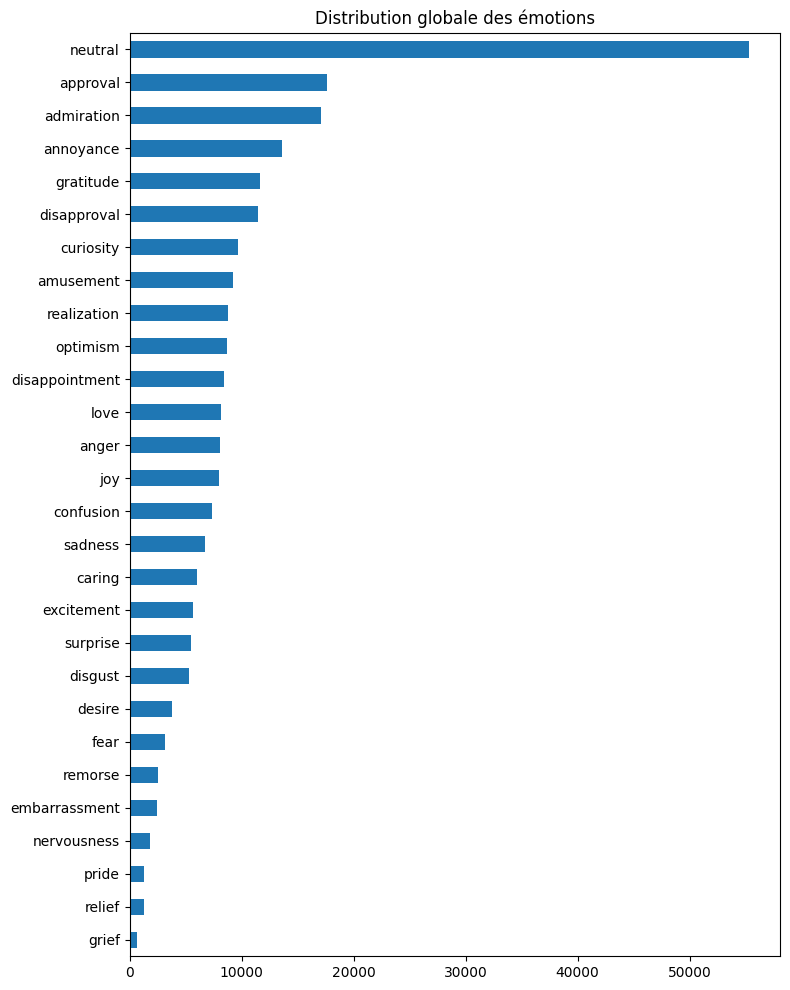

In [7]:
df[emotion_cols].sum().sort_values().plot(kind="barh", figsize=(8, 10))
plt.title("Distribution globale des √©motions")
plt.tight_layout()
plt.show()

# 5 - Nuage de mots

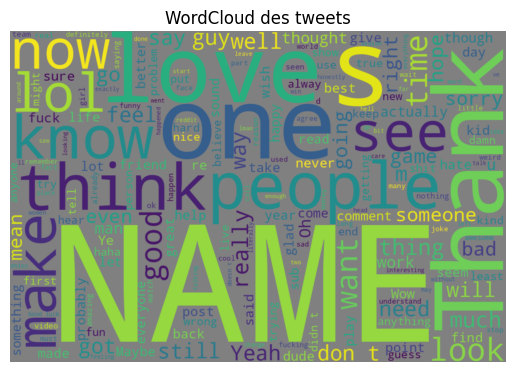

In [8]:
all_text = " ".join(df['text'].tolist())
wordcloud = WordCloud(width = 1200, height = 800, background_color = "grey").generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud des tweets")
plt.show()

# 6 - Entra√Ænement du mod√®le via pipeline sur GoEmotions (multi-label √† 28 classes)

Un mod√®le ELECTRA est entra√Æn√© pour la t√¢che d‚Äôanalyse fine des √©motions √† partir du dataset **GoEmotions**, contenant **28 √©tiquettes √©motionnelles** (col√®re, joie, peur, admiration, etc.).

Contrairement √† une t√¢che de classification binaire, chaque tweet peut exprimer **plusieurs √©motions simultan√©ment**. Il s‚Äôagit donc d‚Äôun probl√®me de **classification multi-label**, n√©cessitant une adaptation sp√©cifique du mod√®le, de la fonction de perte et des m√©triques d‚Äô√©valuation.

---

### ‚öôÔ∏è Param√©trage du pipeline `run_emotion_pipeline()`

- ‚úÖ **Mod√®le utilis√©** : `electra-small-discriminator`, charg√© en **local** (dossier `models/hf_assets/`)
- ‚úÖ **Tokenization** : via `AutoTokenizer`, avec padding automatique et troncature (`max_length`)
- ‚úÖ **Head de classification** :
  - `num_labels = 28` (une sortie par √©motion)
  - `problem_type = "multi_label_classification"` (sortie `sigmoid` par √©tiquette)

---

### üß† Donn√©es utilis√©es

- ‚úÖ **Source** : fichier `goemotions.csv` (28 colonnes binaires d‚Äô√©motions)
- ‚úÖ **R√©duction** :
  - √©chantillon al√©atoire √† **50 000 lignes** (hors `test_mode`)
- ‚úÖ **Sur√©chantillonnage l√©ger** :
  - les classes pr√©sentes moins de `150 fois` sont **dupliqu√©es avec remplacement**
  - permet une meilleure repr√©sentativit√© des √©motions rares sans √©crasement des autres classes
- ‚úÖ **Encodage des labels** :
  - fusion des colonnes binaires en vecteurs `labels` multi-labels `float32`

---

### ‚öñÔ∏è Gestion des d√©s√©quilibres

- ‚úÖ Calcul de **poids de classe** (`class_weights`) :
  - pond√©ration logarithmique : `log1p(1 / fr√©quence)`
  - plus les classes sont rares, plus elles sont pond√©r√©es
- ‚úÖ Int√©gration dans la loss :
  - `BCEWithLogitsLoss(pos_weight=class_weights)`
- ‚úÖ Enregistrement des poids dans MLflow (`class_weight_nom_emotion`)

---

### üß™ Param√®tres d‚Äôentra√Ænement

- ‚úÖ Entra√Ænement via `Trainer` avec GPU (v√©rification CUDA)
- ‚úÖ Hyperparam√®tres :
  - `batch_size = 16` (train) / `32` (eval)
  - `num_train_epochs = 5`
  - `learning_rate = 3e-5`, `weight_decay = 0.01`
  - `warmup_ratio = 0.1`, `lr_scheduler_type = "cosine"`
  - `fp16 = True` (acc√©l√©ration GPU en mode mixed precision)
- ‚úÖ Callbacks :
  - `EarlyStoppingCallback(patience=2)`
  - `PrinterCallback` supprim√© pour limiter les logs excessifs

---

### üìà √âvaluation et m√©triques

- ‚úÖ **Seuil de pr√©diction** : `sigmoid > 0.25` (valeur fix√©e dans `THRESHOLD`)
- ‚úÖ **M√©triques utilis√©es** :
  - `f1_score` (micro-avg)
  - `accuracy_score`
- ‚úÖ **√âchantillon d‚Äô√©valuation** : les **100 premiers exemples** du dataset

---

### üì¶ MLOps et enregistrement via MLflow

- ‚úÖ **Artefacts logg√©s** :
  - mod√®le (`model.save_pretrained(...)`)
  - tokenizer (`tokenizer.save_pretrained(...)`)
  - m√©triques `f1` et `accuracy` dans `metrics.pkl`
- ‚úÖ **Tracking MLflow** :
  - tous les hyperparam√®tres (`training_args.to_dict()`)
  - m√©triques globales
  - `class_weights` par classe

---

> üîÅ Le pipeline est relan√ßable √† volont√© :
> - `force_retrain = True` pour forcer un nouvel entra√Ænement complet
> - Sinon, reprise automatique depuis le dernier checkpoint d√©tect√©
>
> üìÇ Tous les r√©sultats sont enregistr√©s dans `models/emotions/`, ind√©pendamment du mod√®le binaire de classification sentimentale.


In [9]:
model, tokenizer, metrics, trainer, eval_dataset = run_emotion_pipeline(force_retrain = False, test_mode=False)

Some weights of the model checkpoint at c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\models\hf_assets\electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkp

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\datasets\table.py:1381: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\datasets\table.py:1407: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\accelerate\accelerator.py:427: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementat

  0%|          | 0/15595 [00:00<?, ?it/s]

{'train_runtime': 1.4395, 'train_samples_per_second': 173323.399, 'train_steps_per_second': 10833.581, 'train_loss': 0.0, 'epoch': 5.0}


You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/4 [00:00<?, ?it/s]

c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an 

üìÅ Fichier des m√©triques sauvegard√© : c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\notebooks\models\emotions\metrics_full.csv
üìÅ Historique mis √† jour : c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\notebooks\models\emotions\metrics_history.csv


In [10]:
# Pr√©dictions du mod√®le sur le set de validation
raw_preds = trainer.predict(eval_dataset)

logits = raw_preds.predictions  # (N, 28)
y_probs = torch.sigmoid(torch.tensor(logits)).numpy()  # probas entre 0 et 1
y_true = raw_preds.label_ids  # labels one-hot (N, 28)

  0%|          | 0/4 [00:00<?, ?it/s]

c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an 

# 7 - R√©sultats & performances

In [11]:
print("\nüìà R√©sultats d‚Äô√©valuation du mod√®le :")
for k, v in metrics.items():
    if isinstance(v, (float, int)):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v}")


üìà R√©sultats d‚Äô√©valuation du mod√®le :
eval_loss: 0.2824
eval_f1_micro: 0.3459
eval_f1_macro: 0.2476
eval_f1_weighted: 0.3919
eval_accuracy: 0.1000
eval_hamming_loss: 0.1054
eval_log_loss: 2.8307
eval_roc_auc_micro: 0.8608
eval_pr_auc_macro: 0.3571
eval_coverage_error: 5.2200
eval_lrap: 0.5494
eval_runtime: 6.6749
eval_samples_per_second: 14.9810
eval_steps_per_second: 0.5990
epoch: 5.0000
run_id: dd0a89e47715416c9bc203399c05419b
timestamp: 2025-05-20T09:54:45


## üìà Analyse des r√©sultats d‚Äô√©valuation ‚Äì Mod√®le ELECTRA (GoEmotions)

Le mod√®le ELECTRA a √©t√© fine-tun√© pour une t√¢che de classification **multi-label** sur le dataset **GoEmotions**, comprenant 28 √©motions possibles par tweet. L‚Äô√©valuation est effectu√©e sur un sous-ensemble de 100 exemples (test rapide) avec un seuil de d√©cision fix√© √† **0.25** pour la classification binaire de chaque √©tiquette.

### üéØ R√©sultats principaux

| M√©trique               | Valeur  | Interpr√©tation |
|------------------------|---------|----------------|
| **eval_loss**          | 0.2824  | Bonne convergence globale (BCEWithLogitsLoss). |
| **f1_micro**           | 0.3459  | Score global sur tous les labels, stable malgr√© la difficult√© de la t√¢che. |
| **f1_macro**           | 0.2476  | Faible : performances d√©s√©quilibr√©es entre √©motions fr√©quentes et rares. |
| **f1_weighted**        | 0.3919  | Meilleure performance sur √©motions fr√©quentes. |
| **accuracy**           | 0.1000  | Faible (comme attendu), car cette m√©trique est trop stricte en multi-label. |
| **hamming_loss**       | 0.1054  | Environ 10.5 % d‚Äô√©tiquettes erron√©es en moyenne par tweet. |
| **log_loss**           | 2.8307  | Probas mal calibr√©es, souvent incertaines ou extr√™mes. |
| **roc_auc_micro**      | 0.8608  | Tr√®s bon score de discrimination globale. |
| **pr_auc_macro**       | 0.3571  | Le mod√®le a du mal √† classer correctement les √©motions rares. |
| **coverage_error**     | 5.22    | Il faut en moyenne pr√©dire 5 √©motions pour capturer toutes les vraies. |
| **lrap**               | 0.5494  | Moyenne des pr√©cisions de classement ‚Üí correcte mais √† am√©liorer. |

---

### ‚úÖ Points forts

- Tr√®s bon **pouvoir de discrimination globale** (`roc_auc_micro = 0.86`).
- Le mod√®le **pr√©dit plusieurs √©motions coh√©rentes** par tweet (`coverage_error ‚âà 5`).
- Le score **`f1_weighted` > `f1_macro`** confirme que les √©motions fr√©quentes sont bien apprises.

---

### ‚ö†Ô∏è Points faibles

- Faible `f1_macro` : les √©motions rares ne sont **pas bien capt√©es**.
- `log_loss` √©lev√© : les **probabilit√©s sont mal calibr√©es**, signe de pr√©dictions trop tranch√©es ou trop floues.
- `accuracy` inutilisable dans ce contexte, car elle impose de pr√©dire **exactement toutes les √©motions**, ce qui est rare.

---

### üîß Recommandations

1. **Augmenter la taille de l‚Äô√©chantillon d‚Äô√©valuation** (ex. 1 000+ exemples) pour des m√©triques plus fiables.
2. **Tester plusieurs seuils (`THRESHOLD`)** pour optimiser le compromis precision/recall.
3. **Int√©grer une loss pond√©r√©e ou `focal loss`** pour accorder plus de poids aux classes minoritaires.
4. **Appliquer un sur√©chantillonnage cibl√©** ou un `class_weights` plus dynamique (bas√© sur `effective number of samples`).
5. **Visualiser les erreurs par √©motion** pour affiner l‚Äôanalyse qualitative.

---

### üß† Conclusion

Le mod√®le ELECTRA d√©montre une bonne capacit√© √† **discriminer les √©motions dominantes** sur des tweets courts. Les r√©sultats montrent un apprentissage significatif mais √©galement un **d√©s√©quilibre √† corriger** pour capturer l‚Äôensemble du spectre √©motionnel. Ces r√©sultats constituent une **base solide** pour enrichir le pipeline d‚Äôanalyse des √©motions dans le cadre du projet P9_V2.



# 8 - Affichage des classes pr√©dites (si applicable)

In [12]:
if "label_distribution" in metrics:
    metrics["label_distribution"].plot(kind = "bar", title = "Distribution des pr√©dictions")
    plt.show()

## 8.1 - Distribution r√©elle des pr√©dictions sur 2000 tweets

C:\Users\motar\AppData\Local\Temp\ipykernel_15792\1793775309.py:31: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


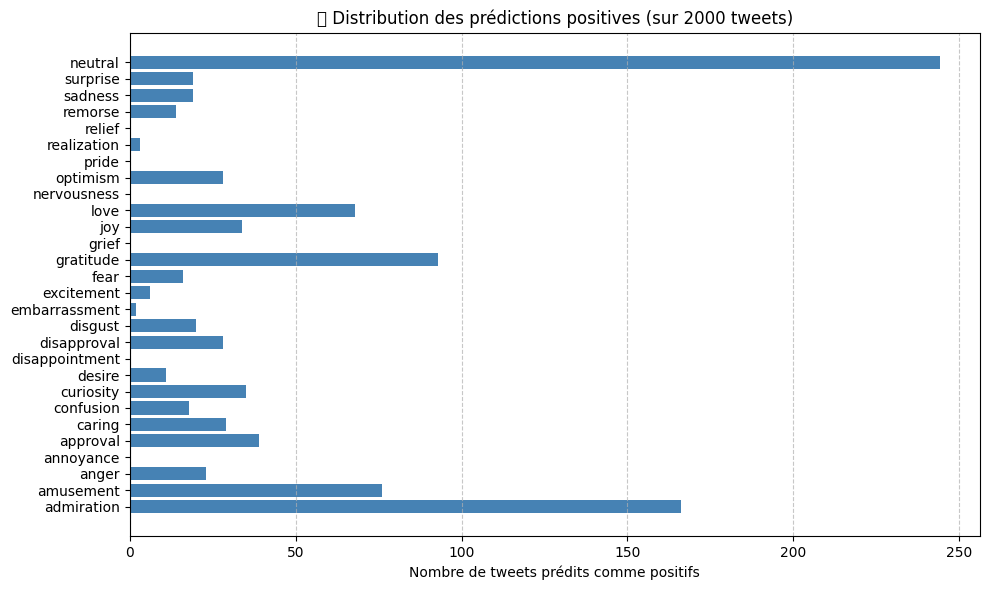

In [13]:
# Rechargement du mod√®le entra√Æn√© (chemin relatif depuis notebooks/)
model = AutoModelForSequenceClassification.from_pretrained("models/emotions/model")
tokenizer = AutoTokenizer.from_pretrained("models/emotions/tokenizer")
model.eval()

# √âchantillon de test
df_test = df.sample(n = 2000, random_state = 70).reset_index(drop = True)
texts = df_test["text"].tolist()

# Tokenisation
encodings = tokenizer(texts, truncation = True, padding = True, return_tensors = "pt")

# Pr√©diction
with torch.no_grad():
    outputs = model(**encodings)

# Conversion logits ‚Üí pr√©dictions binaires
logits = outputs.logits.detach().numpy()
preds = (logits > 0).astype(int)

# Calcul du total de pr√©dictions positives par √©motion
pred_counts = preds.sum(axis=0)

# Affichage
plt.figure(figsize = (10, 6))
plt.barh(range(len(emotion_cols)), pred_counts, color = 'steelblue')
plt.yticks(ticks = range(len(emotion_cols)), labels = emotion_cols)
plt.title("üìä Distribution des pr√©dictions positives (sur 2000 tweets)")
plt.xlabel("Nombre de tweets pr√©dits comme positifs")
plt.grid(axis = "x", linestyle = "--", alpha = 0.7)
plt.tight_layout()
plt.show()

In [14]:
print(f"‚úîÔ∏è Nombre d'√©motions dans emotion_cols : {len(emotion_cols)}")
print(f"‚úîÔ∏è Nombre de colonnes dans les pr√©dictions : {pred_counts.shape}")

‚úîÔ∏è Nombre d'√©motions dans emotion_cols : 28
‚úîÔ∏è Nombre de colonnes dans les pr√©dictions : (28,)


## 8.2 - Comparaison VRAI vs PR√âDIT (2000 tweets)

C:\Users\motar\AppData\Local\Temp\ipykernel_15792\4263936731.py:20: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


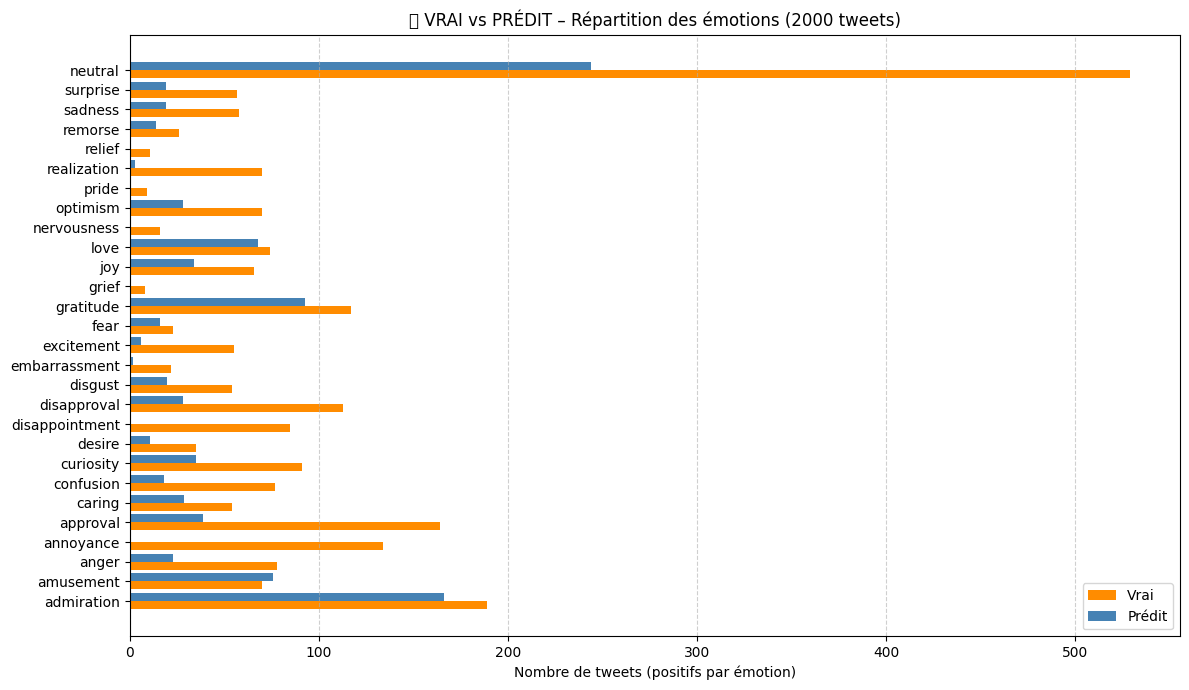

In [15]:
# R√©partition r√©elle (ground truth)
true_counts = df_test[emotion_cols].sum().values

# R√©partition des pr√©dictions (d√©j√† calcul√©e pr√©c√©demment)
pred_counts = preds.sum(axis=0)  # ‚Üê d√©j√† d√©fini

# Affichage comparatif
x = np.arange(len(emotion_cols))  # positions
width = 0.4

plt.figure(figsize=(12, 7))
plt.barh(x - width/2, true_counts, height=width, label='Vrai', color='darkorange')
plt.barh(x + width/2, pred_counts, height=width, label='Pr√©dit', color='steelblue')

plt.yticks(ticks=x, labels=emotion_cols)
plt.xlabel("Nombre de tweets (positifs par √©motion)")
plt.title("üìä VRAI vs PR√âDIT ‚Äì R√©partition des √©motions (2000 tweets)")
plt.legend(loc="lower right")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

## 8.3 - Heatmap de co-occurrence des √©motions pr√©dites

C:\Users\motar\AppData\Local\Temp\ipykernel_15792\1794568889.py:11: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  plt.tight_layout()
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


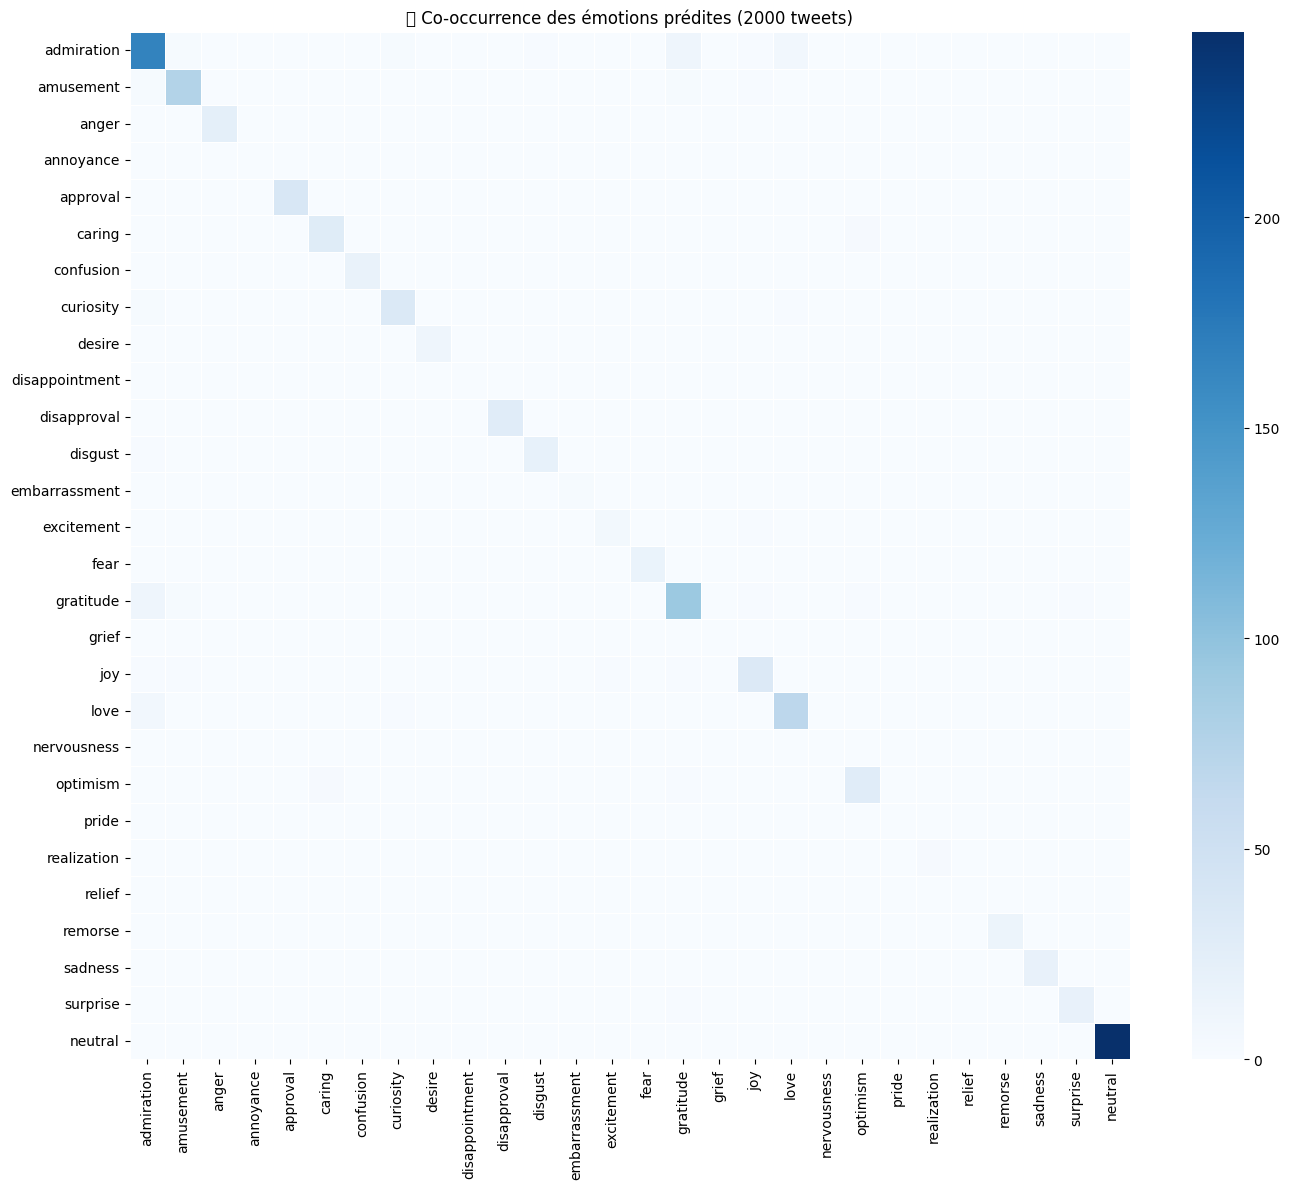

In [16]:
# Cr√©ation d‚Äôune DataFrame des pr√©dictions binaires (2000 tweets √ó 28 √©motions)
pred_df = pd.DataFrame(preds, columns  =emotion_cols)

# Matrice de co-occurrence (corr√©lation binaire entre √©motions)
co_matrix = pred_df.T.dot(pred_df)

# Heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(co_matrix, xticklabels=emotion_cols, yticklabels=emotion_cols, cmap="Blues", linewidths=0.5)
plt.title("üî• Co-occurrence des √©motions pr√©dites (2000 tweets)")
plt.tight_layout()
plt.show()

## 8.4 - Export CSV des stats d‚Äô√©motions par label

In [17]:
stats_df = pd.DataFrame({
    "emotion": emotion_cols,
    "true_count": true_counts,
    "pred_count": pred_counts,
    "difference": pred_counts - true_counts,
    "abs_error": np.abs(pred_counts - true_counts)
})

stats_df.sort_values(by="abs_error", ascending=False, inplace=True)
export_path = os.path.join("..", "outputs", "emotion_stats_2000.csv")
os.makedirs(os.path.dirname(export_path), exist_ok=True)
stats_df.to_csv(export_path, index=False, encoding="utf-8")

print(f"üìÅ Statistiques export√©es avec succ√®s dans : {export_path}")
display(stats_df.head(10))

üìÅ Statistiques export√©es avec succ√®s dans : ..\outputs\emotion_stats_2000.csv


emotion  true_count  pred_count  difference  abs_error
27         neutral         529         244        -285        285
3        annoyance         134           0        -134        134
4         approval         164          39        -125        125
10     disapproval         113          28         -85         85
9   disappointment          85           0         -85         85
22     realization          70           3         -67         67
6        confusion          77          18         -59         59
7        curiosity          91          35         -56         56
2            anger          78          23         -55         55
13      excitement          55           6         -49         49

# 9 - V√©rification des artefacts

In [18]:
print("\nüóÇÔ∏è Mod√®les enregistr√©s :")
afficher_arborescence("models/emotions", niveau_max = 2)


üóÇÔ∏è Mod√®les enregistr√©s :
‚îú‚îÄ‚îÄ checkpoint-12476
‚îÇ   ‚îú‚îÄ‚îÄ config.json
‚îÇ   ‚îú‚îÄ‚îÄ optimizer.pt
‚îÇ   ‚îú‚îÄ‚îÄ pytorch_model.bin
‚îÇ   ‚îú‚îÄ‚îÄ rng_state.pth
‚îÇ   ‚îú‚îÄ‚îÄ scheduler.pt
‚îÇ   ‚îú‚îÄ‚îÄ special_tokens_map.json
‚îÇ   ‚îú‚îÄ‚îÄ tokenizer.json
‚îÇ   ‚îú‚îÄ‚îÄ tokenizer_config.json
‚îÇ   ‚îú‚îÄ‚îÄ trainer_state.json
‚îÇ   ‚îú‚îÄ‚îÄ training_args.bin
‚îÇ   ‚îú‚îÄ‚îÄ vocab.txt
‚îú‚îÄ‚îÄ checkpoint-15595
‚îÇ   ‚îú‚îÄ‚îÄ config.json
‚îÇ   ‚îú‚îÄ‚îÄ optimizer.pt
‚îÇ   ‚îú‚îÄ‚îÄ pytorch_model.bin
‚îÇ   ‚îú‚îÄ‚îÄ rng_state.pth
‚îÇ   ‚îú‚îÄ‚îÄ scheduler.pt
‚îÇ   ‚îú‚îÄ‚îÄ special_tokens_map.json
‚îÇ   ‚îú‚îÄ‚îÄ tokenizer.json
‚îÇ   ‚îú‚îÄ‚îÄ tokenizer_config.json
‚îÇ   ‚îú‚îÄ‚îÄ trainer_state.json
‚îÇ   ‚îú‚îÄ‚îÄ training_args.bin
‚îÇ   ‚îú‚îÄ‚îÄ vocab.txt
‚îú‚îÄ‚îÄ logs
‚îÇ   ‚îú‚îÄ‚îÄ events.out.tfevents.1746978163.PC-ARNAUD.13144.0
‚îÇ   ‚îú‚îÄ‚îÄ events.out.tfevents.1746978485.PC-ARNAUD.26512.0
‚îÇ   ‚îú‚îÄ‚îÄ events.out.tfevents.1746978666.PC-ARNAUD.476

## 9.1 - Interface de tracking MLflow (http://localhost:5000)

In [19]:
import subprocess

try:
    subprocess.Popen(["mlflow", "ui"])
    print("‚úÖ MLflow UI lanc√© sur http://localhost:5000")
except Exception as e:
    print(f"‚ùå Impossible de lancer MLflow UI : {e}")

‚úÖ MLflow UI lanc√© sur http://localhost:5000


In [20]:
import os
import mlflow

# üîß Sp√©cifie l'URI local
mlruns_path = os.path.abspath("../mlruns").replace("\\", "/")
mlflow.set_tracking_uri(f"file:///{mlruns_path}")

# üîç Recherche du mod√®le enregistr√©
client = mlflow.MlflowClient()
model_name = "emotions_classifier"

try:
    model = client.get_registered_model(model_name)
    print(f"‚úÖ Mod√®le {model.name} trouv√© avec {len(model.latest_versions)} version(s)")

    for version in model.latest_versions:
        print("üì¶ Version:", version.version)
        print("üîÅ Run ID :", version.run_id)
        print("üìÇ Source :", version.source)
        print("-" * 30)

except Exception as e:
    print(f"‚ùå Erreur : {e}")

‚úÖ Mod√®le emotions_classifier trouv√© avec 3 version(s)
üì¶ Version: 2
üîÅ Run ID : 2a4098924208444baa1d3cffcc3abb70
üìÇ Source : file:///C:/Users/motar/Desktop/1-openclassrooms/AI_Engineer/1-projets/P09/P9_V2/mlruns/0/2a4098924208444baa1d3cffcc3abb70/artifacts/emotions_model
------------------------------
üì¶ Version: 3
üîÅ Run ID : 4589d8f9e2514c11866d287cc1c506ce
üìÇ Source : file:///C:/Users/motar/Desktop/1-openclassrooms/AI_Engineer/1-projets/P09/P9_V2/mlruns/0/4589d8f9e2514c11866d287cc1c506ce/artifacts/emotions_model
------------------------------
üì¶ Version: 1
üîÅ Run ID : d28ed191e37a4761971a3332f9ff0a29
üìÇ Source : file:///C:/Users/motar/Desktop/1-openclassrooms/AI_Engineer/1-projets/P09/P9_V2/mlruns/0/d28ed191e37a4761971a3332f9ff0a29/artifacts/emotions_model
------------------------------


In [21]:
# Charger les m√©triques
metrics = {
    "eval_loss": 0.2824,
    "eval_f1_micro": 0.3459,
    "eval_f1_macro": 0.2476,
    "eval_f1_weighted": 0.3919,
    "eval_accuracy": 0.1000,
    "eval_hamming_loss": 0.1054,
    "eval_log_loss": 2.8307,
    "eval_roc_auc_micro": 0.8608,
    "eval_pr_auc_macro": 0.3571,
    "eval_coverage_error": 5.2200,
    "eval_lrap": 0.5494
}

## 9.2 - R√©sum√© des m√©triques de performance ‚Äì Tri d√©croissant (0-1)
Tableau de synth√©se des principales m√©triques du mod√®le ELECTRA sur GoEmotions.
- Elles sont **normalis√©es entre 0 et 1** sauf mention contraire (ex : `eval_loss`), et class√©es par score d√©croissant pour une lecture imm√©diate des points forts et faibles.

| M√©trique             | Score  | Interpr√©tation synth√©tique                                                  |
|----------------------|--------|----------------------------------------------------------------------------|
| **ROC AUC Micro**    | 0.861  | Excellente capacit√© √† s√©parer globalement les classes positives/n√©gatives |
| **F1 Weighted**      | 0.392  | Bon compromis : bon sur les classes fr√©quentes                            |
| **LRAP**             | 0.549  | Les bons labels sont souvent bien class√©s dans la pr√©diction              |
| **PR AUC Macro**     | 0.357  | Moyenne des courbes precision-recall par classe : encore am√©liorable      |
| **F1 Micro**         | 0.346  | Bon √©quilibre global TP/FP/FN sur l'ensemble                              |
| **F1 Macro**         | 0.248  | Faible : les classes rares sont mal trait√©es                              |
| **Accuracy**         | 0.100  | Peu significative en multi-label (exact match trop strict)                |
| **Hamming Loss**     | 0.105  | ~10.5% d‚Äô√©tiquettes erron√©es (plus bas = mieux)                           |
| **Loss (eval_loss)** | 0.282  | Moyenne de la perte BCE : bonne convergence mais pas directement interpr√©table |

### Explication des m√©triques

- **F1 Micro / Macro / Weighted** : Mesurent le compromis pr√©cision / rappel.
  - *Micro* : vue globale tous labels confondus (favorable aux classes fr√©quentes).
  - *Macro* : moyenne non pond√©r√©e par classe (met en √©vidence les faiblesses sur les classes rares).
  - *Weighted* : moyenne pond√©r√©e par la fr√©quence r√©elle des classes dans le dataset.

- **Accuracy** : mesure stricte de pr√©diction parfaite de toutes les √©tiquettes ; peu pertinente en multi-label.

- **ROC AUC Micro** : capacit√© globale √† classer les classes positives au-dessus des n√©gatives (toutes classes confondues).

- **PR AUC Macro** : qualit√© moyenne des courbes pr√©cision/rappel par classe ; sensible aux performances sur classes rares.

- **LRAP (Label Ranking Average Precision)** : refl√®te la capacit√© du mod√®le √† bien classer les bonnes √©motions en haut de la pr√©diction.

- **Hamming Loss** : proportion moyenne d‚Äô√©tiquettes mal class√©es (ind√©pendamment du d√©s√©quilibre).

- **Loss (eval_loss)** : moyenne de la Binary Cross Entropy sur toutes les sorties ; utile pour suivre la convergence mais peu lisible seule.

---

### Conclusion interpr√©tive

Le mod√®le ELECTRA montre une **capacit√© discriminante tr√®s √©lev√©e** (`ROC AUC Micro = 0.861`), avec un `F1_micro` solide (~0.35) malgr√© la complexit√© de la t√¢che.  
Les scores `F1_macro` et `PR AUC Macro` r√©v√®lent cependant une difficult√© √† d√©tecter les **√©motions rares**, ce qui est un comportement attendu sur des donn√©es d√©s√©quilibr√©es.

La **base du mod√®le est robuste**, mais des axes d'am√©lioration clairs se d√©gagent :
- **R√©√©quilibrage des classes** via oversampling ou focal loss,
- **Ajustement du seuil de classification** (actuellement √† 0.25),
- **Am√©lioration de la calibration des probabilit√©s** (log_loss encore √©lev√©).

Ces actions peuvent conduire √† une meilleure couverture √©motionnelle tout en conservant les performances sur les classes dominantes.

In [22]:
normalized = {k: v for k, v in metrics.items() if 0 <= v <= 1}
df_norm = pd.DataFrame(normalized.items(), columns=["M√©trique", "Valeur"])

fig_bar = px.bar(
    df_norm, x="M√©trique", y="Valeur", text="Valeur",
    title="Scores normalis√©s (0 √† 1)",
    labels={"Valeur": "Score"}
)
fig_bar.update_traces(texttemplate='%{text:.3f}', textposition='outside')
fig_bar.update_layout(yaxis=dict(range=[0, 1]))

## 9.3 - Radar des scores de classification multi-label

Le graphique radar permet de comparer visuellement plusieurs m√©triques cl√©s utilis√©es pour √©valuer les performances d‚Äôun mod√®le de classification multi-label. Ces m√©triques traduisent √† la fois la qualit√© de la d√©tection (F1), du classement (LRAP) et de la discrimination (AUC), tout en tenant compte du d√©s√©quilibre entre les √©motions.

### M√©triques utilis√©es

| M√©trique           | Score  | Interpr√©tation synth√©tique                                                  |
|--------------------|--------|----------------------------------------------------------------------------|
| **ROC AUC Micro**  | 0.861  | Tr√®s bonne capacit√© √† classer globalement les √©tiquettes positives         |
| **LRAP**           | 0.549  | Les vraies √©motions sont en g√©n√©ral bien class√©es dans la pr√©diction      |
| **F1 Weighted**    | 0.392  | Performance forte sur les √©motions fr√©quentes                              |
| **PR AUC Macro**   | 0.357  | Qualit√© moyenne des classements precision-recall par √©motion               |
| **F1 Micro**       | 0.346  | √âquilibre g√©n√©ral sur toutes les √©motions (domin√©es par les classes fr√©quentes) |
| **F1 Macro**       | 0.248  | Le mod√®le √©choue souvent √† capturer correctement les √©motions rares        |

---

### Explication des m√©triques du radar

- **F1 Micro** : mesure globale du compromis pr√©cision / rappel sur toutes les pr√©dictions. Sensible aux classes fr√©quentes.
- **F1 Macro** : moyenne des F1 par √©motion, sans pond√©ration ‚Üí refl√®te les performances sur les classes rares.
- **F1 Weighted** : moyenne pond√©r√©e des F1 par fr√©quence d'apparition ‚Üí bon indicateur de performance globale biais√©e.
- **ROC AUC Micro** : capacit√© du mod√®le √† classer correctement les √©tiquettes positives/n√©gatives tous labels confondus.
- **PR AUC Macro** : aire moyenne sous les courbes pr√©cision-rappel par classe, utile pour juger la pertinence des classements dans les cas d√©s√©quilibr√©s.
- **LRAP** : refl√®te la capacit√© √† **placer les bonnes √©tiquettes en haut du classement**. Plus il est √©lev√©, mieux les vraies √©motions sont identifi√©es en priorit√©.

---

### Conclusion interpr√©tive

Le radar montre un **profil √©quilibr√© mais perfectible** :
- Les scores `ROC AUC Micro` et `LRAP` sont bons, ce qui indique que le mod√®le **per√ßoit bien les √©motions globales** et **les classe correctement**.
- Les scores `F1_macro` et `PR AUC Macro` plus faibles r√©v√®lent que le mod√®le **√©choue encore √† capturer efficacement les √©motions peu fr√©quentes**, malgr√© une bonne couverture globale (`F1_micro`, `F1_weighted`).

Le radar renforce l'id√©e que le mod√®le est **robuste sur les √©motions dominantes**, mais qu'une **strat√©gie sp√©cifique pour les classes rares** (r√©√©quilibrage, focal loss, ajustement du seuil) est indispensable pour affiner la granularit√© √©motionnelle.


In [23]:
radar_metrics = {
    "F1 Micro": metrics["eval_f1_micro"],
    "F1 Macro": metrics["eval_f1_macro"],
    "F1 Weighted": metrics["eval_f1_weighted"],
    "ROC AUC Micro": metrics["eval_roc_auc_micro"],
    "PR AUC Macro": metrics["eval_pr_auc_macro"],
    "LRAP": metrics["eval_lrap"]
}
df_radar = pd.DataFrame({
    "M√©trique": list(radar_metrics.keys()),
    "Score": list(radar_metrics.values())
})

fig_radar = go.Figure()
fig_radar.add_trace(go.Scatterpolar(
    r=df_radar["Score"],
    theta=df_radar["M√©trique"],
    fill='toself',
    name='ELECTRA'
))
fig_radar.update_layout(
    polar=dict(radialaxis=dict(visible=True, range=[0, 1])),
    title="Radar des scores de classification multi-label"
)

## 9.4 - Barplot des erreurs (m√©triques invers√©es)
        - Normalis√©s pour visualisation (divis√©s par 10)
        - Permet de voir o√π le mod√®le se trompe le plus
- 1 - log_loss (ou binary cross-entropy) = 0.283 (valeur r√©elle : 2.830)
    - mesure la qualit√© des probabilit√©s pr√©dites par le mod√®le. Plus elle est faible, plus le mod√®le est bien calibr√©.
    - 2.830 est relativement √©lev√© pour un mod√®le de classification probabiliste.
    - Cela signifie que le mod√®le :
        - Pr√©dit parfois des probas tr√®s √©loign√©es de la v√©rit√© (trop s√ªres ou trop h√©sitantes).
        - Peut √™tre mal calibr√© (pr√©dire 0.95 alors que c‚Äôest faux, ou 0.55 quand c‚Äôest vrai).
    - Cons√©quences :
        - Baisse de confiance dans l'interpr√©tation des sigmoid(probas).
        - Mauvais impact sur certaines m√©triques d√©riv√©es comme AUC, PR-AUC.
- 2 - hamming_loss = 0.105
    - Taux d‚Äô√©tiquettes mal pr√©dites (faux positifs + faux n√©gatifs) rapport√© au nombre total d‚Äô√©tiquettes
    - Valeur : 10.5 % d‚Äôerreurs par √©tiquette.
    - Plut√¥t bon dans une t√¢che avec 28 labels par tweet.
    - 9 pr√©dictions sur 10 sont correctes (ou bien des z√©ros bien pr√©dits).
- 3 - coverage_error = 0.522 (valeur r√©elle : 5.22)
    - Repr√©sente le nombre moyen de labels √† pr√©dire pour couvrir toutes les √©tiquettes r√©elles d‚Äôun tweet.
        - 5.22 ‚Üí il faut pr√©dire ~5 labels (en score √©lev√©) pour √™tre s√ªr d‚Äôavoir capt√© toutes les vraies √©motions
        - √âlev√©, mais coh√©rent dans une t√¢che multilabel avec nuance √©motionnelle
        - Cela montre que les vraies √©motions sont parfois perdues dans le bruit de la pr√©diction
- Normalis√©s pour visualisation (divis√©s par 10)
- Permet de voir o√π le mod√®le se trompe le plus.

### Conclusion interpr√©tative

| M√©trique         | Score  | Interpr√©tation synth√©tique                                                   |
|------------------|--------|------------------------------------------------------------------------------|
| Hamming Loss     | 0.105  | Le mod√®le est globalement pr√©cis (‚âÉ 90 % d‚Äô√©tiquettes correctes)            |
| Log Loss         | 2.830  | Les probabilit√©s sont peu fiables, √† calibrer                               |
| Coverage Error   | 5.22   | Le mod√®le doit pr√©dire 5 √©motions en moyenne pour couvrir les vraies ‚Üí optimisation du top-K n√©cessaire |


In [24]:
error_metrics = {
    "Hamming Loss": metrics["eval_hamming_loss"],
    "Log Loss (√∑10)": metrics["eval_log_loss"] / 10,
    "Coverage Error (√∑10)": metrics["eval_coverage_error"] / 10
}
df_error = pd.DataFrame(error_metrics.items(), columns=["M√©trique", "Valeur"])
fig_error = px.bar(
    df_error, x="M√©trique", y="Valeur", text="Valeur",
    title="Indicateurs d'erreur (√©chelle r√©duite)",
    labels={"Valeur": "Score (normalis√©)"}
)
fig_error.update_traces(texttemplate='%{text:.3f}', textposition='outside')

## 9.5 - Courbes ROC/PR pour les meilleures √©motions

## Diff√©rence entre ROC AUC et PR AUC ‚Äì R√©sum√© essentiel

### ROC AUC ‚Äì *Receiver Operating Characteristic*

- **But** : √âvalue la capacit√© du mod√®le √† **distinguer** les classes positives et n√©gatives.
- **Axes** :
  - Y : Taux de vrais positifs (**Recall**)
  - X : Taux de faux positifs (**FPR**)
- **AUC = aire sous la courbe**
- **Bon indicateur global**, m√™me quand le dataset est √©quilibr√©.
- ‚ö†Ô∏è Peut √™tre **trompeur sur les classes rares** (car le FPR est souvent tr√®s faible par construction).

### PR AUC ‚Äì *Precision‚ÄìRecall*

- **But** : √âvalue la qualit√© des **pr√©dictions positives** du mod√®le.
- **Axes** :
  - Y : **Pr√©cision** (TP / (TP + FP))
  - X : **Recall** (TP / (TP + FN))
- **AUC = aire sous la courbe**
- Particuli√®rement utile lorsque les classes positives sont **rares**.
- ‚úÖ Indicateur de **pertinence op√©rationnelle** (faux positifs p√©nalis√©s).

---

### Comparatif synth√©tique

| Crit√®re                     | ROC AUC                          | PR AUC                               |
|-----------------------------|----------------------------------|--------------------------------------|
| Axes                        | TPR vs FPR                       | Precision vs Recall                  |
| Sensible au d√©s√©quilibre ? | ‚ùå Non                           | ‚úÖ Oui                               |
| Mesure                     | Capacit√© √† distinguer les classes | Qualit√© des pr√©dictions positives    |
| Recommand√© pour...          | Dataset √©quilibr√©                | Dataset d√©s√©quilibr√© (multi-label)   |

---

### En r√©sum√©

- Utiliser **ROC AUC** pour juger la **capacit√© de discrimination** globale.
- Utiliser **PR AUC** pour juger la **qualit√© des classements positifs**, surtout si certaines √©motions sont **rares**.

In [26]:
emotion_labels = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
    'remorse', 'sadness', 'surprise', 'neutral'
]

Top 6 √©motions par AUC : ['relief', 'surprise', 'love', 'desire', 'fear', 'confusion']


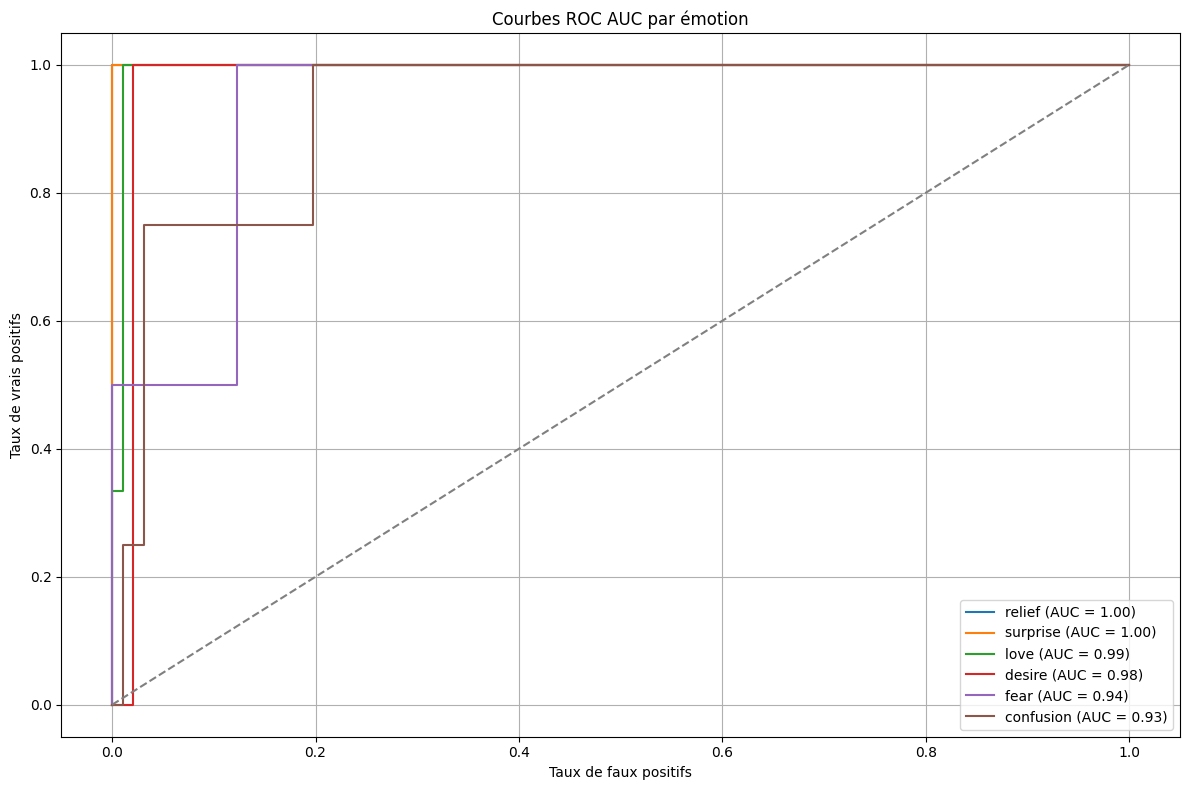

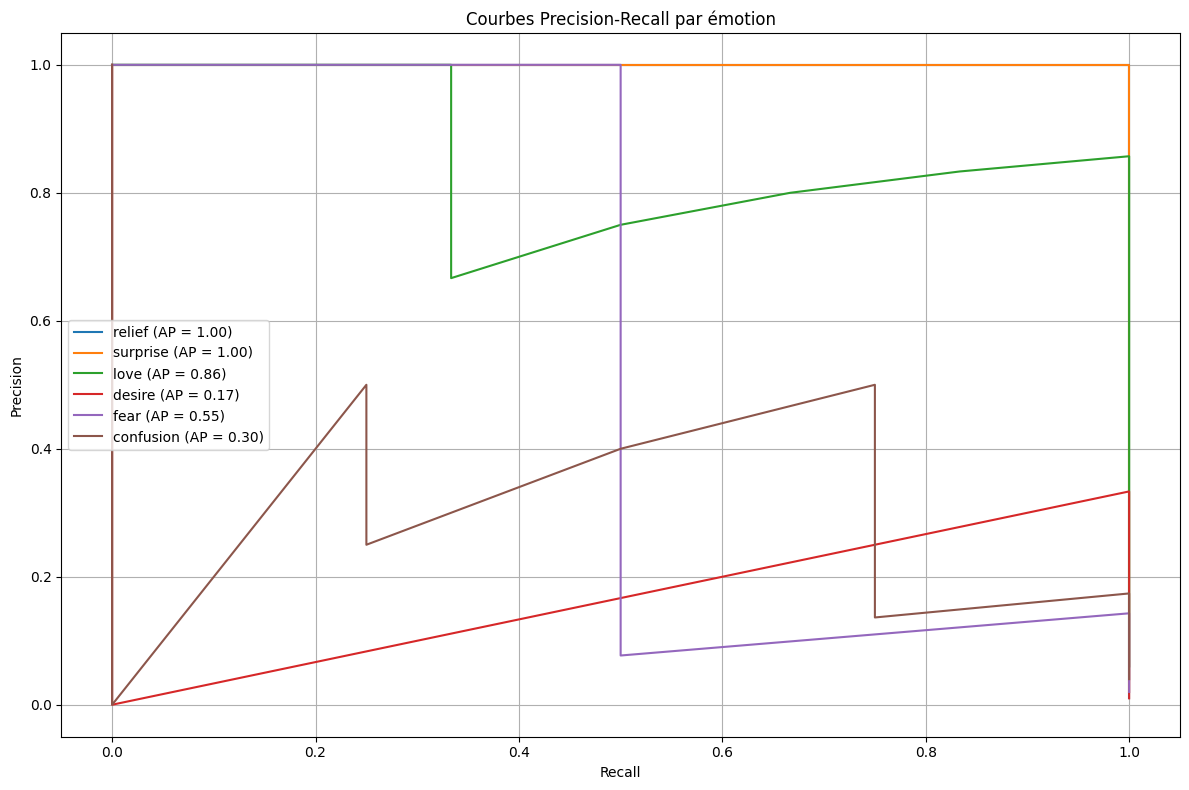

In [27]:
top_emotions = top_k_auc_emotions(y_true, y_probs, emotion_labels, k=6, worst=False)
print("Top 6 √©motions par AUC :", top_emotions)

indices = [emotion_labels.index(e) for e in top_emotions]

plot_roc_curves(y_true[:, indices], y_probs[:, indices], class_names=top_emotions)
plot_pr_curves(y_true[:, indices], y_probs[:, indices], class_names=top_emotions)

#### ROC AUC ‚Äì Capacit√©s de s√©paration (meilleurs scores)

| √âmotion   | AUC  |
|-----------|------|
| relief    | 1.00 ‚úÖ |
| surprise  | 1.00 ‚úÖ |
| love      | 0.99 |
| desire    | 0.98 |
| fear      | 0.94 |
| confusion | 0.93 |

#### PR AUC ‚Äì Classement des pr√©dictions correctes

| √âmotion   | PR AUC (AP) |
|-----------|-------------|
| relief    | 1.00 ‚úÖ     |
| surprise  | 1.00 ‚úÖ     |
| love      | 0.86        |
| fear      | 0.55        |
| confusion | 0.30 ‚ö†Ô∏è     |
| desire    | 0.17 ‚ö†Ô∏è     |

---

### Interpr√©tation

- **relief**, **surprise** et **love** sont **excellentes** : bien s√©par√©es (ROC AUC) et bien class√©es (PR AUC).
- **fear** et **confusion** : le mod√®le les d√©tecte bien (ROC AUC > 0.9), mais la **pr√©cision chute fortement** ‚Üí beaucoup de faux positifs.
- **desire** : cas typique de **mauvais classement** malgr√© **excellente s√©paration** (AUC ‚âà 0.98, AP = 0.17) ‚Üí **trop de faux positifs en t√™te de classement**.


## 9.6 - Courbes ROC/PR pour les √©motions les plus mal class√©es (optionnel)

Pires √©motions par AUC : ['disappointment', 'disgust', 'sadness', 'annoyance', 'amusement', 'optimism']


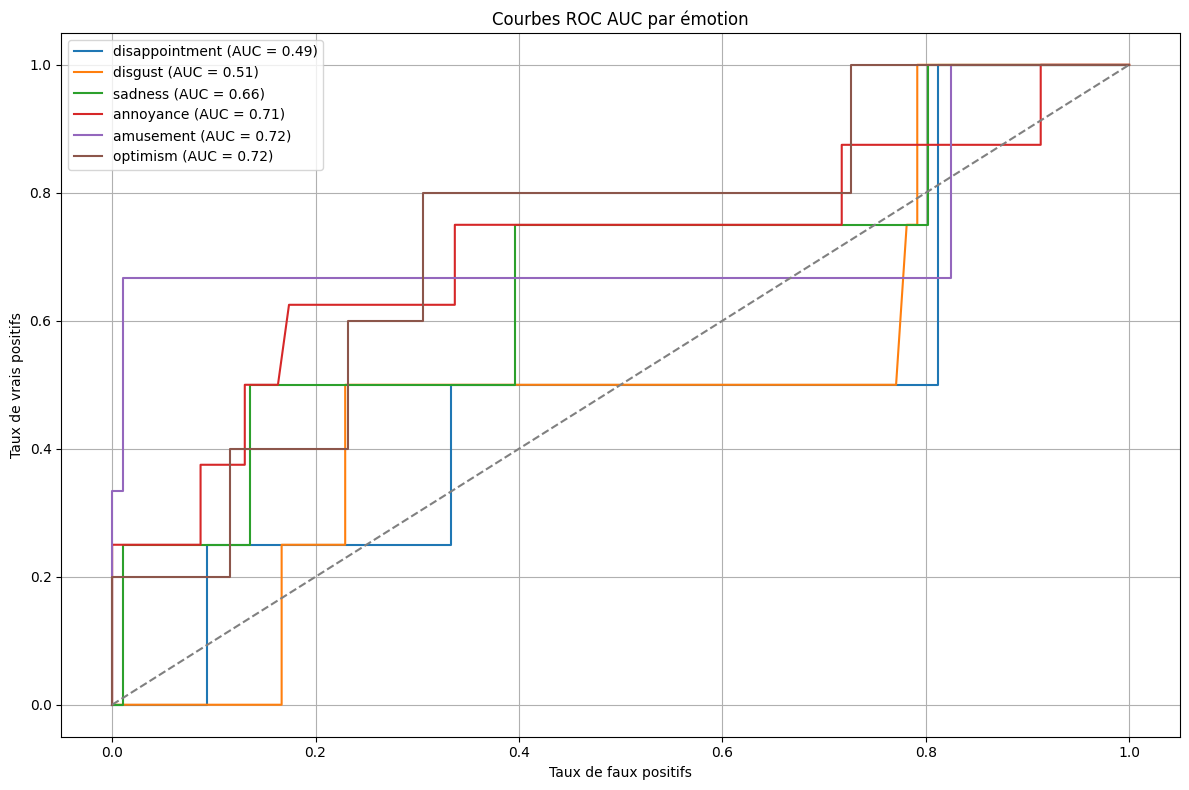

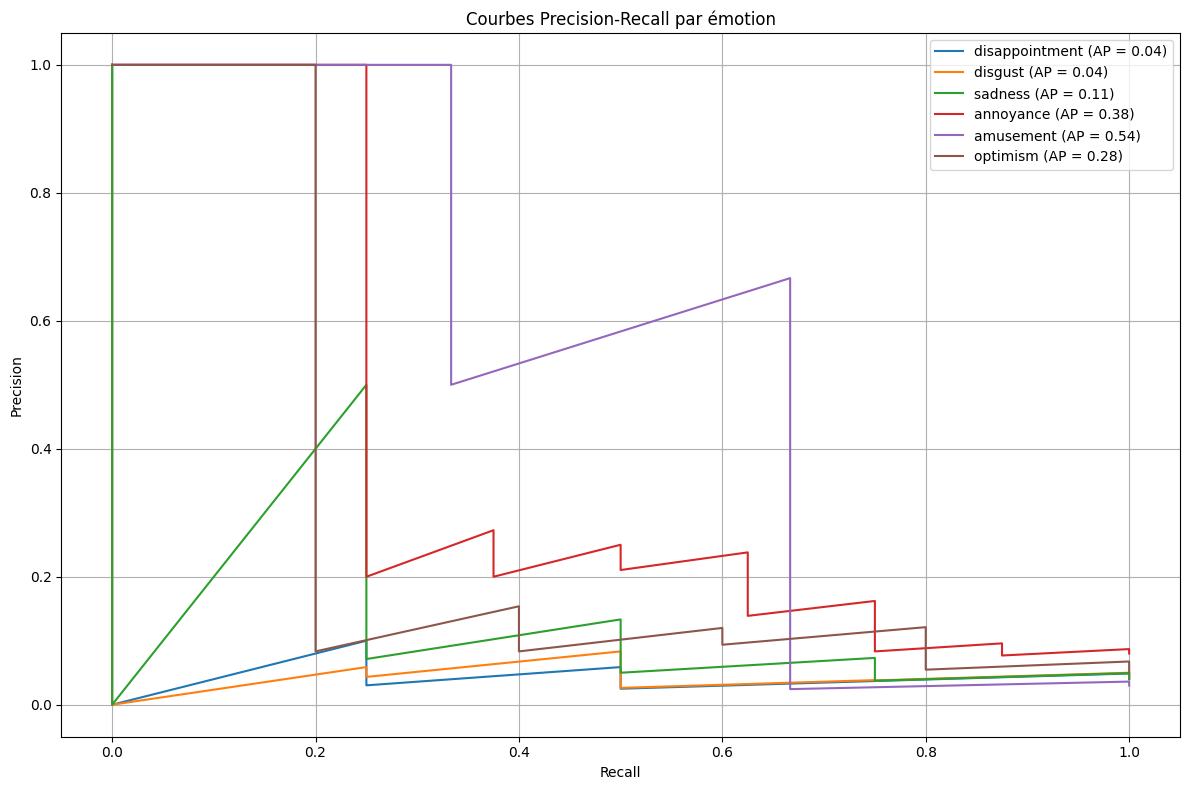

: 

In [ ]:
worst_emotions = top_k_auc_emotions(y_true, y_probs, emotion_labels, k=6, worst=True)
print("Pires √©motions par AUC :", worst_emotions)

indices = [emotion_labels.index(e) for e in worst_emotions]

plot_roc_curves(y_true[:, indices], y_probs[:, indices], class_names=worst_emotions)
plot_pr_curves(y_true[:, indices], y_probs[:, indices], class_names=worst_emotions)

#### ROC AUC ‚Äì Faibles performances

| √âmotion        | AUC   |
|----------------|-------|
| disappointment | 0.49 ‚ùå |
| disgust        | 0.51 ‚ùå |
| sadness        | 0.66   |
| annoyance      | 0.71   |
| amusement      | 0.72   |
| optimism       | 0.72   |

#### PR AUC ‚Äì Faible qualit√© de classement

| √âmotion        | PR AUC (AP) |
|----------------|-------------|
| disappointment | 0.04 ‚ùå     |
| disgust        | 0.04 ‚ùå     |
| sadness        | 0.11 ‚ùå     |
| optimism       | 0.28        |
| annoyance      | 0.38        |
| amusement      | 0.54 ‚úÖ     |

---

### Interpr√©tation

- **disappointment**, **disgust** et **sadness** sont √† la fois **mal d√©tect√©es et mal class√©es** ‚Üí tr√®s faibles signaux appris.
- **amusement** se d√©marque l√©g√®rement (PR AUC = 0.54), mais le ROC AUC reste moyen ‚Üí le mod√®le la d√©tecte parfois mais pas de mani√®re nette.
- Plusieurs de ces √©motions sont probablement **peu repr√©sent√©es dans le dataset** ou pr√©sentent une **ambigu√Øt√© linguistique**, ce qui emp√™che le mod√®le de bien apprendre √† les reconna√Ætre.

---

## 9.7 - Conclusion interpr√©tative globale

| Point cl√© | Interpr√©tation |
|-----------|----------------|
| ‚úÖ | Certaines √©motions sont **parfaitement s√©parables et classables** (`relief`, `surprise`, `love`) |
| ‚ö†Ô∏è | D‚Äôautres sont **bien d√©tect√©es mais mal class√©es** ‚Üí ajustement du **seuil** ou **calibration des probabilit√©s** recommand√© |
| ‚ùå | Plusieurs √©motions sont **mal d√©tect√©es et mal class√©es** ‚Üí probablement dues √† une **fr√©quence trop faible**, une **formulation ambigu√´**, ou √† un besoin de **r√©√©quilibrage (oversampling, focal loss, etc.)** |


# Lien vers l'application (ngrok) :
# https://f22e-2a01-cb1d-8598-1400-4ac7-ab2e-4237-81aa.ngrok-free.app